In [2]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import logging
import numpy as np
from pylab import rcParams
import seaborn as sb
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets
from collections import Counter
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import scipy
from scipy.spatial import distance

%matplotlib inline

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
routes = pd.read_csv("~/Documents/jtnp_routesAndDesc_joined_reducedv2.csv")
# This needs to become a SQL query, to be set as a table. Then, exclude any rows with the descriptors selected
# as an input parameter - 'I don't want X type of route.'
coords = routes.as_matrix(columns=['latitude', 'longitude'])


//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [4]:
kms_per_radian = 6371.0088
epsilon = .1 / kms_per_radian
min_sample=10
db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 42


In [5]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find the point in each cluster that is closest to its centroid
centermost_points = []
for cluster in clusters.iteritems():
    if len(cluster[1]) >= min_sample:
        centermost_points.append(get_centermost_point(cluster[1]))
        #print(centermost_points)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

rs = rep_points.apply(lambda row: routes[(routes['latitude']==row['lat']) & (routes['longitude']==row['lon'])].iloc[0], axis=1)
rs_centroids = rs[['latitude','longitude']]
#rs_centroids

campsites = pd.read_csv("~/Documents/jtnp_campsite_coords.csv")

In [6]:
rs_centroids

,latitude,longitude
0,34.0148,-116.1654
1,34.0285,-116.1451
2,34.0183,-116.1635
3,33.9941,-116.1429
4,34.0202,-116.1650
5,34.0143,-116.1583
6,33.9978,-116.1536
7,34.0030,-116.1495
8,33.9964,-116.1555
9,33.9893,-116.1634


In [7]:
input = "2020-08-01"

forecastabbrev10 = pd.read_csv("~/Documents/campgroundpredictions_twoyears.csv")
az = forecastabbrev10.loc[forecastabbrev10['date'] == input]
az
az2=az[['belle_yhat','br_yhat','cw_yhat','hv_yhat','ic_yhat','jr_yhat','ryan_yhat','wt_yhat']]
az3=pd.DataFrame(az2)
az3.columns=['Belle','Black Rock','Cottonwood','Hidden Valley','Indian Cove','Jumbo Rocks','Ryan','White Tank']
az31=pd.melt(az2)
campsites.columns=['variable','latitude','longitude']
az3 = pd.merge(az31, campsites, on='variable')
az3=az3.sort_values('value')
az3=az3.reset_index()
bestcamp = (az3['variable'][0])
bcocc = (az3['value'][0])
bestcamp2 = (az3['variable'][1])
bcocc2 = (az3['value'][1])
bestcamp3 = (az3['variable'][2])
bcocc3 = (az3['value'][2])
print('Camps by Likelihood of Availability on',input)
print()
print('Best Camp: ')
print(bestcamp)
print('Predicted Monthly Occupancy: ',bcocc)
print()
print('Next Best Camp: ')
print(bestcamp2)
print('Predicted Monthly Occupancy: ', bcocc2)
print()
print('Third Best Camp: ')
print(bestcamp3)
print('Predicted Monthly Occupancy: ',bcocc3)
print()

Camps by Likelihood of Availability on 2020-08-01

Best Camp: 
Jumbo Rocks
Predicted Monthly Occupancy:  0.12341014307754615

Next Best Camp: 
Cottonwood
Predicted Monthly Occupancy:  0.12906751618343204

Third Best Camp: 
Black Rock
Predicted Monthly Occupancy:  0.13399351682054206



In [126]:
az3

,index,variable,value,latitude,longitude
0,5,Jumbo Rocks,0.123410,33.9919,-116.0625
1,2,Cottonwood,0.129068,33.7429,-115.8151
2,1,Black Rock,0.133994,34.0736,-116.3901
3,4,Indian Cove,0.182289,34.0948,-116.1594
4,3,Hidden Valley,0.256105,34.0170,-116.1615
5,6,Ryan,0.469544,33.9830,-116.1547
6,0,Belle,0.638408,34.0018,-116.0203
7,7,White Tank,0.645145,33.9848,-116.0167


In [11]:
forecastabbrev10 = pd.read_csv("~/Documents/campgroundpredictions_twoyears.csv")
az = forecastabbrev10.loc[forecastabbrev10['date'] == input]
az
az2=az[['belle_yhat','br_yhat','cw_yhat','hv_yhat','ic_yhat','jr_yhat','ryan_yhat','wt_yhat']]
az3=pd.DataFrame(az2)
az3.columns=['Belle','Black Rock','Cottonwood','Hidden Valley','Indian Cove','Jumbo Rocks','Ryan','White Tank']
az3=pd.melt(az2)

In [20]:
az3

,index,variable,value,latitude,longitude
0,5,Jumbo Rocks,0.123410,33.9919,-116.0625
1,2,Cottonwood,0.129068,33.7429,-115.8151
2,1,Black Rock,0.133994,34.0736,-116.3901
3,4,Indian Cove,0.182289,34.0948,-116.1594
4,3,Hidden Valley,0.256105,34.0170,-116.1615
5,6,Ryan,0.469544,33.9830,-116.1547
6,0,Belle,0.638408,34.0018,-116.0203
7,7,White Tank,0.645145,33.9848,-116.0167


In [10]:
y10=az3['latitude'][0]
y10

33.9919

In [13]:
x10=az3['longitude'][0]
array = np.array([y10, x10])
array

array([  33.9919, -116.0625])

In [22]:
from scipy.spatial import cKDTree
import numpy as np

rs_c = rs_centroids.as_matrix()
points_ref = rs_c
tree = cKDTree(points_ref)
_, idx = tree.query(array, k=2)
points_ref[idx]

//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


array([[  34.0182, -116.0737],
       [  33.9664, -116.0872]])

In [42]:
# Finding the Day 1 Climbing Clusters

from scipy.spatial import cKDTree
import numpy as np

rs_c = rs_centroids.as_matrix()
points_ref = rs_c
tree = cKDTree(points_ref)
_, idx = tree.query(array, k=1)
pref2 = points_ref[idx]

tree = cKDTree(points_ref)
_, idx2 = tree.query(pref2, k=2)
points_ref[idx2]


//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[  34.0182, -116.0737],
       [  34.0462, -116.1033]])

In [63]:
# Printing out the individual route coordinates for the cluster closest to campsite
pr4 = points_ref[idx2]
climb1 = pr4[0,:] 
climb1 [0]
centroid_row = rs_centroids.loc[rs_centroids['latitude'] == climb1[0]]
cri = centroid_row.index[0]
c1routes = clusters[cri]
c1routes

array([[  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737],
       [  34.0182, -116.0737]])

In [65]:
# Printing out the individual route coordinates for the cluster 2nd closest to campsite
pr4 = points_ref[idx2]
climb2 = pr4[1,:] 
climb2 [0]
centroid_row2 = rs_centroids.loc[rs_centroids['latitude'] == climb2[0]]
cri2 = centroid_row2.index[0]
c2routes = clusters[cri]
c2routes

array([[  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.046 , -116.1043],
       [  34.0462, -116.1033],
       [  34.0459, -116.1043],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033],
       [  34.0462, -116.1033]])

In [28]:
len(rs_c)

41

In [67]:
# Finding the Day 2 Climbing Clusters
# Need to set the array as a random coordinate pair from rs_c

from scipy.spatial import cKDTree
import numpy as np
from random import seed
from random import randint 

rs_c = rs_centroids.as_matrix()
points_ref = rs_c
for q in range(1):
    value = randint(0, len(rs_c))
    print(value)
pointd2 = rs_c[value]
tree = cKDTree(points_ref)
_, idx = tree.query(pointd2, k=1)
pref2 = points_ref[idx]

tree = cKDTree(points_ref)
_, idx2 = tree.query(pref2, k=2)
points_ref[idx2]


7


//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array([[  34.003 , -116.1495],
       [  33.9978, -116.1536]])

In [69]:
# Printing out the individual route coordinates for the cluster 1, Day 2
pr5 = points_ref[idx2]
climb3 = pr5[0,:] 
climb3 [0]
centroid_row3 = rs_centroids.loc[rs_centroids['latitude'] == climb3[0]]
cri3 = centroid_row3.index[0]
c3routes = clusters[cri3]
c3routes

array([[  34.0038, -116.1493],
       [  34.0029, -116.149 ],
       [  34.0038, -116.1493],
       [  34.0025, -116.1498],
       [  34.0032, -116.149 ],
       [  34.0038, -116.1493],
       [  34.0032, -116.149 ],
       [  34.0025, -116.1498],
       [  34.0028, -116.1504],
       [  34.0032, -116.149 ],
       [  34.0028, -116.1504],
       [  34.0033, -116.1493],
       [  34.003 , -116.1495],
       [  34.0038, -116.1493],
       [  34.0028, -116.1504],
       [  34.0028, -116.1504],
       [  34.0028, -116.1504],
       [  34.0038, -116.1493],
       [  34.0025, -116.1498],
       [  34.0028, -116.1504]])

In [124]:
# Printing out the individual route coordinates for the cluster 2, Day 2
pr5 = points_ref[idx2]
climb4 = pr5[1,:] 
climb4 [0]
centroid_row4 = rs_centroids.loc[rs_centroids['latitude'] == climb4[0]]
cri4 = centroid_row4.index[0]
c4routes = clusters[cri4]
c4routes

array([[  33.9978, -116.1536],
       [  33.9979, -116.1543],
       [  33.9979, -116.1534],
       [  33.9976, -116.1542],
       [  33.998 , -116.1535],
       [  33.9976, -116.1542],
       [  33.998 , -116.1535],
       [  33.9979, -116.1543],
       [  33.9979, -116.1534],
       [  33.998 , -116.1535],
       [  33.9976, -116.1542],
       [  33.998 , -116.1535]])

In [126]:
c4routes[:,0]

array([33.9978, 33.9979, 33.9979, 33.9976, 33.998 , 33.9976, 33.998 ,
       33.9979, 33.9979, 33.998 , 33.9976, 33.998 ])

In [148]:
# This takes the coordinates of routes from a given cluster, returns a reduced list of unique coordinates
# (no overlap/duplicates), and creates a new pandas data frame with just the routes in this cluster.

def delete_duplicate_pairs(*arrays):
    unique = set()
    arrays = list(arrays)
    n = range(len(arrays))
    index = 0
    for pair in zip(*arrays):
        if pair not in unique:
            unique.add(pair)
            for i in n:
                arrays[i][index] = pair[i]
            index += 1
    return [a[:index] for a in arrays]

a1=c4routes[:,0]
a2=c4routes[:,1]
a1, a2 = delete_duplicate_pairs(a1, a2)

rsub = pd.DataFrame()

for i in range(len(a1)):
    xco = a1[i]
    xc1 = a2[i]
    rsub1 = routes.loc[(routes['latitude'] == xco) & (routes['longitude'] == xc1)]
    rsub = rsub.append(rsub1)
    
rsub

,index,id,name,type,rating,diffcategory,diffcatnum,stars,starvotes,pitches,location,url,imgsqsmall,imgsmall,imgsmallmed,imgmedium,longitude,latitude,description
16,16,107905741,Nicole Overhang,Boulder,V6,hard,3,4.0,46,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10790574...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,-116.1536,33.9978,Stand start with right hand sidepull in the di...
79,79,108682718,Unnamed,Boulder,V3,medium,2,3.7,15,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10868271...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,-116.1536,33.9978,"On the left side of the nicole boulder, climb ..."
48,48,108734026,Saxwing on the DL,Boulder,V5,hard,3,4.0,20,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10873402...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,-116.1543,33.9979,"start on right facing jug rail, gain a high di..."
205,205,112816641,Nibiru,Boulder,V9,hard,3,3.0,1,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11281664...,NaN,NaN,NaN,NaN,-116.1543,33.9979,"Start at high sidepulls, climb over the bulge ..."
71,71,111505610,The Sideling,Boulder,V3,medium,2,4.1,9,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11150561...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,-116.1534,33.9979,Start at a good rail 6 or so feet right of the...
220,220,106649438,The Real Slam Dunk,Boulder,V3,medium,2,3.0,1,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10664943...,NaN,NaN,NaN,NaN,-116.1534,33.9979,This run-and-jump problem kicks off a small ed...
111,111,108745986,Unnamed Crack,Boulder,V5,hard,3,3.7,7,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10874598...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,-116.1542,33.9976,A great climb. A sit down start is possible (v...
145,145,108746083,Obvious Gem,Boulder,V5,hard,3,3.4,8,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10874608...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,-116.1542,33.9976,Start sitting with a right heel hook and slope...
521,523,111735651,Unknown,Boulder,V1,medium,2,3.0,5,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11173565...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,-116.1542,33.9976,"Climb Loose edges/plates up and left, on the o..."
179,179,114085260,Mulligan Mantle,Boulder,V3,medium,2,3.0,3,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11408526...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/1141

In [163]:
rsub
diff1 = "easy"
diff2 = "medium"
diff3 = "hard"

dfc = pd.DataFrame(rsub['diffcategory'].value_counts())
dfc.columns=['catcount']
print(dfc.loc[diff1,:] >= 2)
print(dfc.loc[diff2,:] >= 2)
print(dfc.loc[diff3,:] >= 2)

catcount    False
Name: easy, dtype: bool
catcount    True
Name: medium, dtype: bool
catcount    True
Name: hard, dtype: bool


In [140]:
a1=c4routes[:,0]
a2=c4routes[:,1]
a1, a2 = delete_duplicate_pairs(a1, a2)

rsub = pd.DataFrame()

for i in range(len(a1)):
    xco = a1[i]
    xc1 = a2[i]
    rsub1 = routes.loc[(routes['latitude'] == xco) & (routes['longitude'] == xc1)]
    rsub = rsub.append(rsub1)
    
rsub

array([33.9978, 33.9979, 33.9979, 33.9976, 33.998 ])

In [145]:
rsub = pd.DataFrame()

for i in range(len(a1)):
    xco = a1[i]
    xc1 = a2[i]
    rsub1 = routes.loc[(routes['latitude'] == xco) & (routes['longitude'] == xc1)]
    rsub = rsub.append(rsub1)
    
rsub

,index,id,name,type,rating,diffcategory,diffcatnum,stars,starvotes,pitches,location,url,imgsqsmall,imgsmall,imgsmallmed,imgmedium,longitude,latitude,description
16,16,107905741,Nicole Overhang,Boulder,V6,hard,3,4.0,46,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10790574...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,https://cdn-files.apstatic.com/climb/107905745...,-116.1536,33.9978,Stand start with right hand sidepull in the di...
79,79,108682718,Unnamed,Boulder,V3,medium,2,3.7,15,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10868271...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,https://cdn-files.apstatic.com/climb/108682729...,-116.1536,33.9978,"On the left side of the nicole boulder, climb ..."
48,48,108734026,Saxwing on the DL,Boulder,V5,hard,3,4.0,20,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10873402...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,https://cdn-files.apstatic.com/climb/112814628...,-116.1543,33.9979,"start on right facing jug rail, gain a high di..."
205,205,112816641,Nibiru,Boulder,V9,hard,3,3.0,1,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11281664...,NaN,NaN,NaN,NaN,-116.1543,33.9979,"Start at high sidepulls, climb over the bulge ..."
71,71,111505610,The Sideling,Boulder,V3,medium,2,4.1,9,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11150561...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,https://cdn-files.apstatic.com/climb/111849023...,-116.1534,33.9979,Start at a good rail 6 or so feet right of the...
220,220,106649438,The Real Slam Dunk,Boulder,V3,medium,2,3.0,1,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10664943...,NaN,NaN,NaN,NaN,-116.1534,33.9979,This run-and-jump problem kicks off a small ed...
111,111,108745986,Unnamed Crack,Boulder,V5,hard,3,3.7,7,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10874598...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,https://cdn-files.apstatic.com/climb/108746079...,-116.1542,33.9976,A great climb. A sit down start is possible (v...
145,145,108746083,Obvious Gem,Boulder,V5,hard,3,3.4,8,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10874608...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,https://cdn-files.apstatic.com/climb/108746141...,-116.1542,33.9976,Start sitting with a right heel hook and slope...
521,523,111735651,Unknown,Boulder,V1,medium,2,3.0,5,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11173565...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,https://cdn-files.apstatic.com/climb/111752671...,-116.1542,33.9976,"Climb Loose edges/plates up and left, on the o..."
179,179,114085260,Mulligan Mantle,Boulder,V3,medium,2,3.0,3,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11408526...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/1141

In [119]:
pairs = set(tuple(sorted(p)) for p in c4routes)
pairs

{(-116.1543, 33.9979),
 (-116.1542, 33.9976),
 (-116.1536, 33.9978),
 (-116.1535, 33.998000000000005),
 (-116.1534, 33.9979)}

In [82]:
c4routes[2,0]
range(len(c4routes))

range(0, 12)

In [105]:
rsub=[]

for i in range(len(c4routes)):
    xco = c4routes[i,0]
    xc1 = c4routes[i,1]
    rsub1 = routes.loc[(routes['latitude'] == xco) & (routes['longitude'] == xc1)]
    rsub.append(rsub1)
    
rsub[6]

,index,id,name,type,rating,diffcategory,diffcatnum,stars,starvotes,pitches,location,url,imgsqsmall,imgsmall,imgsmallmed,imgmedium,longitude,latitude,description
179,179,114085260,Mulligan Mantle,Boulder,V3,medium,2,3.0,3,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/11408526...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/114139998...,https://cdn-files.apstatic.com/climb/114139998...,-116.1535,33.998,"Jump to the sloping lip, mantle."
391,393,106649403,X Offender,Boulder,V2,medium,2,2.7,10,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10664940...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,-116.1535,33.998,Start below the undercut slab and move up on m...
989,991,106649385,Sweetielicious,Boulder,V0-,easy,1,3.2,37,NaN,"{California,""Joshua Tree National Park"",""*Josh...",https://www.mountainproject.com/route/10664938...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,https://cdn-files.apstatic.com/climb/106649417...,-116.1535,33.998,Start from a diagonal crack and some plates wi...


In [62]:
y20=rs_centroids[['latitude','longitude']]
rs_coords = rs_centroids.as_matrix(columns=['latitude', 'longitude'])
rs_coords

//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[  34.0148, -116.1654],
       [  34.0285, -116.1451],
       [  34.0183, -116.1635],
       [  33.9941, -116.1429],
       [  34.0202, -116.165 ],
       [  34.0143, -116.1583],
       [  33.9978, -116.1536],
       [  34.003 , -116.1495],
       [  33.9964, -116.1555],
       [  33.9893, -116.1634],
       [  34.0626, -116.2263],
       [  33.983 , -116.1545],
       [  34.0143, -116.1711],
       [  33.9664, -116.0872],
       [  34.0753, -116.242 ],
       [  33.9423, -116.0782],
       [  34.011 , -116.1661],
       [  34.0101, -116.1687],
       [  34.0127, -116.1684],
       [  34.0441, -116.1061],
       [  34.0121, -116.1773],
       [  34.0135, -116.1544],
       [  34.0808, -116.2462],
       [  33.9962, -116.15  ],
       [  34.0263, -116.1415],
       [  34.0402, -116.1978],
       [  34.0839, -116.2325],
       [  34.0462, -116.1033],
       [  34.0943, -116.1561],
       [  34.0159, -116.1784],
       [  34.0241, -116.1547],
       [  34.0104, -116.1357],
       [

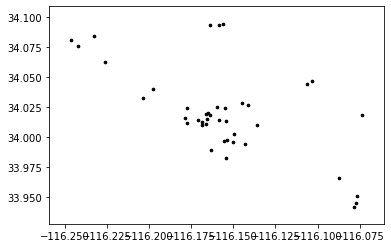

In [133]:
f2 = rs_centroids['latitude'].values
f1 = rs_centroids['longitude'].values
XD = np.array(list(zip(f2, f1)))
plt.scatter(f1, f2, c='black', s=7)

In [139]:
# Number of pairs to be created in the second round of clustering
num_pairs = num_clusters//2

In [144]:
rs_coords = rs_centroids.as_matrix(columns=['latitude', 'longitude'])
#rs_coords

f2 = rs_centroids['latitude'].values
f1 = rs_centroids['longitude'].values
XD = np.array(list(zip(f2, f1)))
#plt.scatter(f1, f2, c='black', s=7)

# Number of pairs to be created in the second round of clustering
num_pairs = num_clusters//2

X = XD   # Data

# K-means clustering
km = KMeans(n_clusters=num_pairs)  # defining the clustering object
km.fit(X)  # actually fitting the data
y_clus = km.labels_   # clustering info resulting from K-means
y_cent = km.cluster_centers_  # centroid coordinates

//anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [170]:
XD

array([[  34.0148, -116.1654],
       [  34.0285, -116.1451],
       [  34.0183, -116.1635],
       [  33.9941, -116.1429],
       [  34.0202, -116.165 ],
       [  34.0143, -116.1583],
       [  33.9978, -116.1536],
       [  34.003 , -116.1495],
       [  33.9964, -116.1555],
       [  33.9893, -116.1634],
       [  34.0626, -116.2263],
       [  33.983 , -116.1545],
       [  34.0143, -116.1711],
       [  33.9664, -116.0872],
       [  34.0753, -116.242 ],
       [  33.9423, -116.0782],
       [  34.011 , -116.1661],
       [  34.0101, -116.1687],
       [  34.0127, -116.1684],
       [  34.0441, -116.1061],
       [  34.0121, -116.1773],
       [  34.0135, -116.1544],
       [  34.0808, -116.2462],
       [  33.9962, -116.15  ],
       [  34.0263, -116.1415],
       [  34.0402, -116.1978],
       [  34.0839, -116.2325],
       [  34.0462, -116.1033],
       [  34.0943, -116.1561],
       [  34.0159, -116.1784],
       [  34.0241, -116.1547],
       [  34.0104, -116.1357],
       [

In [145]:
y_clus

array([ 4,  8, 10, 19, 10, 16,  7,  7,  7, 15, 13, 20,  4, 12,  5,  2,  4,
        4,  4,  6, 14, 16,  5,  7,  8,  0, 17,  6,  3, 14, 18,  1,  9,  0,
       18,  2,  3,  2, 10, 11,  3], dtype=int32)

In [171]:
len(y_clus)

41

In [146]:
y_cent

array([[  34.03635   , -116.2006    ],
       [  34.0104    , -116.1357    ],
       [  33.9463    , -116.07733333],
       [  34.09353333, -116.15936667],
       [  34.01258   , -116.16794   ],
       [  34.07805   , -116.2441    ],
       [  34.04515   , -116.1047    ],
       [  33.99835   , -116.15215   ],
       [  34.0274    , -116.1433    ],
       [  34.0182    , -116.0737    ],
       [  34.0192    , -116.16486667],
       [  34.024     , -116.1772    ],
       [  33.9664    , -116.0872    ],
       [  34.0626    , -116.2263    ],
       [  34.014     , -116.17785   ],
       [  33.9893    , -116.1634    ],
       [  34.0139    , -116.15635   ],
       [  34.0839    , -116.2325    ],
       [  34.02465   , -116.1571    ],
       [  33.9941    , -116.1429    ],
       [  33.983     , -116.1545    ]])

Text(0.5, 1.0, 'Clusters from K-means')

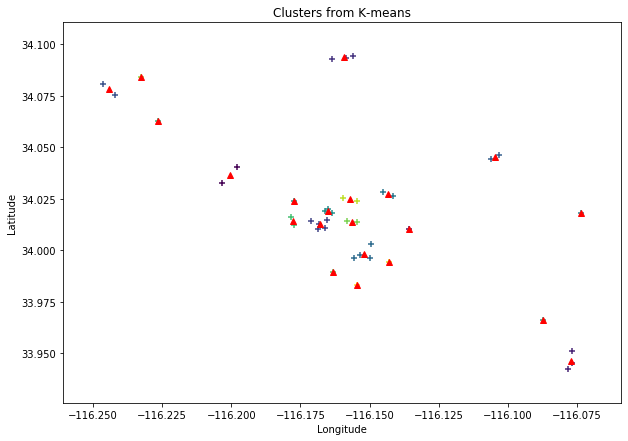

In [152]:
### plotting the clusters
plt.figure(figsize=[10,7])
# First, results from K-means
#plt.subplot(121)
plt.scatter(X[:,1],X[:,0],c=y_clus,marker='+')
plt.plot(y_cent[:,1],y_cent[:,0],'r^')  # Ploting centroids
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters from K-means')

In [148]:
y_cent

array([[  34.03635   , -116.2006    ],
       [  34.0104    , -116.1357    ],
       [  33.9463    , -116.07733333],
       [  34.09353333, -116.15936667],
       [  34.01258   , -116.16794   ],
       [  34.07805   , -116.2441    ],
       [  34.04515   , -116.1047    ],
       [  33.99835   , -116.15215   ],
       [  34.0274    , -116.1433    ],
       [  34.0182    , -116.0737    ],
       [  34.0192    , -116.16486667],
       [  34.024     , -116.1772    ],
       [  33.9664    , -116.0872    ],
       [  34.0626    , -116.2263    ],
       [  34.014     , -116.17785   ],
       [  33.9893    , -116.1634    ],
       [  34.0139    , -116.15635   ],
       [  34.0839    , -116.2325    ],
       [  34.02465   , -116.1571    ],
       [  33.9941    , -116.1429    ],
       [  33.983     , -116.1545    ]])

In [153]:
y_cent[:,0]

array([34.03635   , 34.0104    , 33.9463    , 34.09353333, 34.01258   ,
       34.07805   , 34.04515   , 33.99835   , 34.0274    , 34.0182    ,
       34.0192    , 34.024     , 33.9664    , 34.0626    , 34.014     ,
       33.9893    , 34.0139    , 34.0839    , 34.02465   , 33.9941    ,
       33.983     ])

In [ ]:
# What if the second round of clusters are chosen using DBSCAN again?
# Doesn't really work

kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
min_sample=2
db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(rs_centroids))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([rs_centroids[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [43]:
x20=rs_centroids['longitude']

In [49]:
y20[0]

KeyError: 0

In [35]:
from math import sqrt

points=rs_centroids

def get_ordered_list(points, x10, y10):
   points.sort(key = lambda p: sqrt((p.x - x)**2 + (p.y - y)**2))
   return points

In [46]:
import math
data = y20
data.sort(key=lambda x: math.sqrt((float(x20[0]) - x10)**2 +
                                  (float(y20[1]) - y10)**2))
print(data)

[0    -116.1654
1    -116.1451
2    -116.1635
3    -116.1429
4    -116.1650
5    -116.1583
6    -116.1536
7    -116.1495
8    -116.1555
9    -116.1634
10   -116.2263
11   -116.1545
12   -116.1711
13   -116.0872
14   -116.2420
15   -116.0782
16   -116.1661
17   -116.1687
18   -116.1684
19   -116.1061
20   -116.1773
21   -116.1544
22   -116.2462
23   -116.1500
24   -116.1415
25   -116.1978
26   -116.2325
27   -116.1033
28   -116.1561
29   -116.1784
30   -116.1547
31   -116.1357
32   -116.0737
33   -116.2034
34   -116.1595
35   -116.0768
36   -116.1635
37   -116.0770
38   -116.1661
39   -116.1772
40   -116.1585
Name: longitude, dtype: float64, 0     34.0148
1     34.0285
2     34.0183
3     33.9941
4     34.0202
5     34.0143
6     33.9978
7     34.0030
8     33.9964
9     33.9893
10    34.0626
11    33.9830
12    34.0143
13    33.9664
14    34.0753
15    33.9423
16    34.0110
17    34.0101
18    34.0127
19    34.0441
20    34.0121
21    34.0135
22    34.0808
23    33.9962
24    34.0263
2

In [39]:
rs_centroids['latitude'][0]

34.0148

In [167]:
# centroids to campsite
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

traveling = []

for i in range(len(y_cent)):
    rs_cent_lat = y_cent[:,0]
    rs_cent_long = y_cent[:,1]
    bestcamp_lat = az3['latitude'][0]
    bestcamp_long = az3['longitude'][0]
    lat1 = radians(rs_cent_lat[i])
    lon1 = radians(rs_cent_long[i])
    lat2 = radians(bestcamp_lat)
    lon2 = radians(bestcamp_long)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    distancemi = round((distance / 1.60934), 3)
    traveling.append(distancemi)

print(len(traveling))

21


In [168]:
traveling

[8.487,
 4.385,
 3.264,
 8.951,
 6.208,
 11.985,
 4.403,
 5.156,
 5.239,
 1.928,
 6.161,
 6.936,
 2.261,
 10.579,
 6.783,
 5.785,
 5.588,
 11.629,
 5.874,
 4.61,
 5.308]

In [169]:
y_cent

array([[  34.03635   , -116.2006    ],
       [  34.0104    , -116.1357    ],
       [  33.9463    , -116.07733333],
       [  34.09353333, -116.15936667],
       [  34.01258   , -116.16794   ],
       [  34.07805   , -116.2441    ],
       [  34.04515   , -116.1047    ],
       [  33.99835   , -116.15215   ],
       [  34.0274    , -116.1433    ],
       [  34.0182    , -116.0737    ],
       [  34.0192    , -116.16486667],
       [  34.024     , -116.1772    ],
       [  33.9664    , -116.0872    ],
       [  34.0626    , -116.2263    ],
       [  34.014     , -116.17785   ],
       [  33.9893    , -116.1634    ],
       [  34.0139    , -116.15635   ],
       [  34.0839    , -116.2325    ],
       [  34.02465   , -116.1571    ],
       [  33.9941    , -116.1429    ],
       [  33.983     , -116.1545    ]])